In [1]:
from PIL import Image
import torch 
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from PIL import Image
import torchvision.models as models

import time
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)
set_seeds()

# 1. Prepare Dataset

In [4]:
class Data_Seg_Class(Dataset):
    def __init__(self, img_class_path, img_seg_path, mask_seg_path, transform=None):
        
        self.classifi_path = img_class_path
        self.img_seg_path = img_seg_path
        self.mask_seg_path = mask_seg_path
        self.transform = transform

        name_labels = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

        # lấy tất các file image trong folder classification
        self.images_filename = []
        for i in name_labels:
            for f in os.listdir(self.classifi_path + f'/{i}') :
                if os.path.isfile(os.path.join(self.classifi_path + f'/{i}', f)):
                    self.images_filename.append(os.path.splitext(f)[0])

        # Load dataset phân loại 1 lần duy nhất
        self.class_dataset = datasets.ImageFolder(self.classifi_path)
        self.label_map = {os.path.splitext(os.path.basename(p))[0]: label for p, label in self.class_dataset.samples}

    def __len__(self):
        return len(self.images_filename)

    def __getitem__(self, idx):
        filename = self.images_filename[idx]

        image_path = os.path.join(self.img_seg_path, filename + '.jpg')
        # kiểm tra file ảnh có trong folder segmentation không
        if os.path.isfile(image_path):
            
            mask_path = os.path.join(self.mask_seg_path, filename + '.png')
            
            # Đọc ảnh và mask
            image = np.array(Image.open(image_path).convert('RGB'))
            mask = np.array(Image.open(mask_path).convert('L'))
            mask = (mask > 127).astype(np.float32)
        else:
            image_path_new = os.path.join(self.classifi_path + '/no_tumor', filename + '.jpg')
            image = image = np.array(Image.open(image_path_new).convert('RGB'))
            mask = np.zeros((512, 512), dtype=np.float32)


        # Augmentation
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            mask = torch.unsqueeze(mask, 0)
        # Tìm label tương ứng
        label = self.label_map.get(filename, -1)  # nếu không tìm thấy thì = -1

        return image, mask, label

transform = A.Compose([
        A.Resize(256, 256),
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.1),
        # A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5),
        # A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        # A.GaussNoise(var_limit=(0.01, 0.05), p=0.3),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ], 
    is_check_shapes=False )

In [5]:
img_class_path_train = '/kaggle/input/dataset-brain/data/classification_task/train'
img_seg_path_train = '/kaggle/input/dataset-brain/data/segmentation_task/train/images'
mask_seg_path_train = '/kaggle/input/dataset-brain/data/segmentation_task/train/masks'

img_class_path_test = '/kaggle/input/dataset-brain/data/classification_task/test'
img_seg_path_test = '/kaggle/input/dataset-brain/data/segmentation_task/test/images'
mask_seg_path_test = '/kaggle/input/dataset-brain/data/segmentation_task/test/masks'

In [6]:
train_data = Data_Seg_Class(img_class_path_train, img_seg_path_train, mask_seg_path_train, transform)

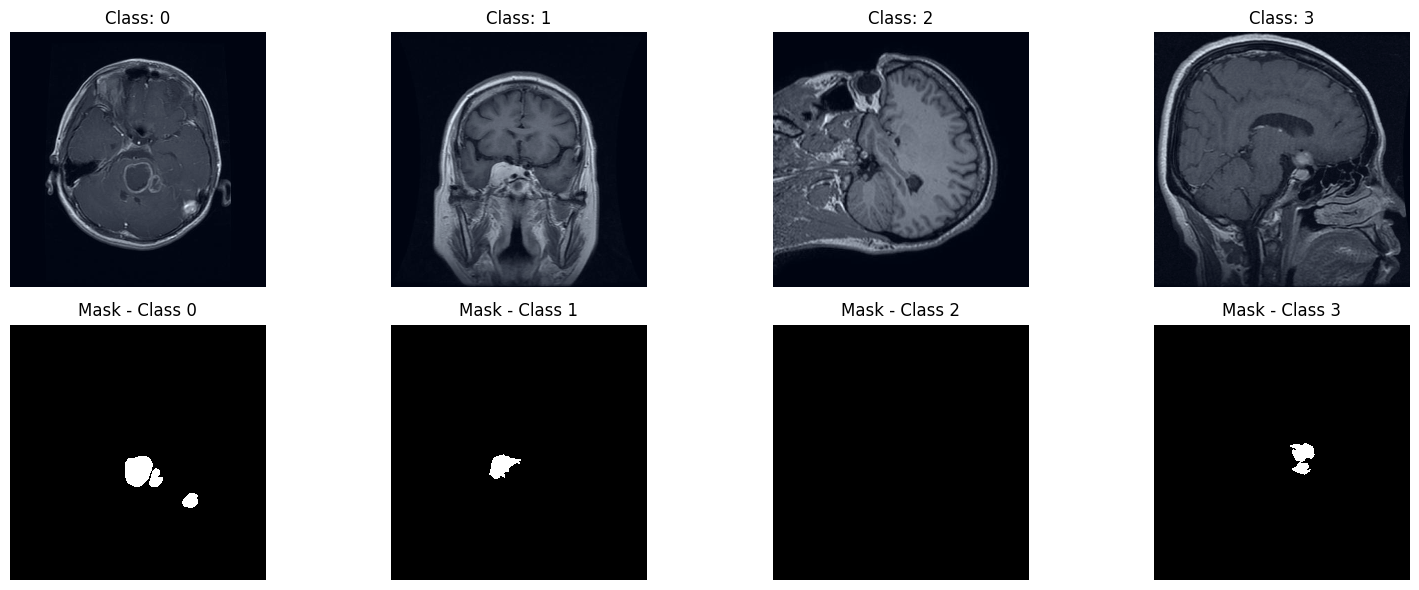

In [7]:
# 1. Tìm kiếm mẫu cho mỗi class
found_samples = {}
num_classes_to_find = 4

# Duyệt qua train_data để nhặt ra mỗi class một ảnh
for i in range(len(train_data)):
    image, mask, label = train_data[i]
    
    # Xử lý nếu label là Tensor
    if isinstance(label, torch.Tensor):
        label = label.item()
    
    # Nếu class này chưa có trong danh sách tìm thấy thì thêm vào
    if label not in found_samples:
        found_samples[label] = (image, mask)
    
    # Nếu đã tìm đủ 4 class thì dừng vòng lặp cho nhanh
    if len(found_samples) == num_classes_to_find:
        break

# Sắp xếp label (0, 1, 2, 3) để hiển thị theo thứ tự
sorted_labels = sorted(found_samples.keys())
num_cols = len(sorted_labels)

# 2. Vẽ hình
if num_cols == 0:
    print("Không tìm thấy dữ liệu nào!")
else:
    # Tạo lưới plot: 2 hàng, số cột = số class tìm được
    fig, ax = plt.subplots(2, num_cols, figsize=(4 * num_cols, 6))

    for i, label in enumerate(sorted_labels):
        image, mask = found_samples[label]

        # --- Hàng 1: Ảnh gốc ---
        # Xử lý để hiển thị đúng định dạng (H, W, C)
        if isinstance(image, torch.Tensor):
            img_show = image.permute(1, 2, 0).cpu().numpy()
            
            # (Tuỳ chọn) Nếu bạn đã Normalize ảnh (trừ mean, chia std), 
            # ảnh hiển thị có thể bị tối hoặc màu lạ. 
            # Dòng dưới đây giúp đưa giá trị về khoảng [0, 1] để dễ nhìn hơn:
            img_show = (img_show - img_show.min()) / (img_show.max() - img_show.min())
        else:
            img_show = image

        # Nếu chỉ có 1 cột (1 class), ax là mảng 1 chiều, nếu nhiều cột là 2 chiều
        if num_cols > 1:
            ax_img = ax[0, i]
            ax_mask = ax[1, i]
        else:
            ax_img = ax[0]
            ax_mask = ax[1]

        ax_img.imshow(img_show)
        ax_img.set_title(f"Class: {label}")
        ax_img.axis('off')

        # --- Hàng 2: Mask ---
        if isinstance(mask, torch.Tensor):
            mask_show = mask.squeeze(0).cpu().numpy()
        else:
            mask_show = mask

        ax_mask.imshow(mask_show, cmap='gray')
        ax_mask.set_title(f"Mask - Class {label}")
        ax_mask.axis('off')

    plt.tight_layout()
    plt.show()

In [8]:
train_size = int(0.8 * len(train_data))
valid_test_size = len(train_data) - train_size

# Chia dữ liệu thành train (80%) và tạm thời là validation/test (20%)
train_dataset, valid_test_dataset = random_split(train_data, [train_size, valid_test_size])

# Tiếp tục chia valid_test_dataset thành validation (10%) và test (10%)
valid_size = int(0.5 * valid_test_size)
test_size = valid_test_size - valid_size
valid_dataset, test_dataset = random_split(valid_test_dataset, [valid_size, test_size])

# You can check the sizes to verify
print(f"Training set: {len(train_dataset)} samples")
print(f"Validation set: {len(valid_dataset)} samples")
print(f"Test set: {len(test_dataset)} samples")

Training set: 4000 samples
Validation set: 500 samples
Test set: 500 samples


In [9]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=32)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=32)

# 3. Load model

In [10]:
class decode(torch.nn.Module):
    def __init__(self, in_channel, middle_channel, out_channel):
        super(decode, self).__init__()
        self.transpose = torch.nn.ConvTranspose2d(in_channel, in_channel, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channel + middle_channel, out_channel, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.relu2 = nn.ReLU(inplace=True)


    def forward(self, x1, x2):
        x1 = self.transpose(x1)
        if x1.size() != x2.size():
            x1 = nn.functional.interpolate(x1, size=x2.shape[2:], 
                                            mode='bilinear', align_corners=False)
            
        x = torch.cat([x1, x2], dim=1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)      
        return x

In [11]:
class MultiTaskModel(nn.Module):
    def __init__(self, n_classes, n_segment, in_channels, input_size=(256,256)):
        super(MultiTaskModel, self).__init__()

        # load pretrained EfficientNet-B4
        efficient = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.DEFAULT)
        features = efficient.features
        
        # encoder
        self.encoder1 = nn.Sequential(
            features[0],
            features[1]
        )
        self.encoder2 = nn.Sequential(
            features[2]
        )
        self.encoder3 = nn.Sequential(
            features[3],
            features[4]
        )
        self.encoder4 = nn.Sequential(
            features[5],
            features[6]
        )
        self.encoder5 = nn.Sequential(
            features[7],
            features[8]
        )

        self.brigde = nn.Sequential(
            nn.BatchNorm2d(1792, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True),
            nn.AdaptiveAvgPool2d(output_size=1),
            nn.Dropout(0.1),
            nn.SiLU(),
        )

        # decoder

        self.decode1 = decode(1792, 272, 256) # In: 1792, Skip: 160
        self.decode2 = decode(256, 112, 128)   # In: 256, Skip: 56
        self.decode3 = decode(128, 32, 64)    # In: 128, Skip: 32
        self.decode4 = decode(64, 24, 32)     # In: 64, Skip: 24
        
        # output segment
        self.segmentation_head = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, n_segment, kernel_size=1)  # Output layer
        )

        # output classify
        self.classify = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=1),
            nn.Flatten(),
            nn.Dropout(p=0.4),
            nn.Linear(in_features=1792,
                      out_features=n_classes,
                      bias=True)
        )

    def forward(self, inputs):
        x1 = self.encoder1(inputs)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)
        x5 = self.encoder5(x4)
        
        x_brigde = self.brigde(x5)

        x6 = self.decode1(x_brigde, x4)
        x7 = self.decode2(x6, x3)
        x8 = self.decode3(x7, x2)
        x9 = self.decode4(x8, x1)

        

        out_classify = self.classify(x5)

        
        out_segment = self.segmentation_head(x9)
        
        return out_classify, out_segment
        

In [12]:
model = MultiTaskModel(n_classes= 4, n_segment=1, in_channels=3, input_size=(256, 256))
model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 193MB/s]


# 4. Code loss

In [13]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predictions, targets):
        # 1. Chuyển logits thành xác suất
        predictions = torch.sigmoid(predictions)

        # 2. Flatten: (Batch_Size, Channel, H, W) -> (Batch_Size, -1)
        # Giữ lại chiều Batch_Size để tính riêng từng ảnh
        predictions = predictions.view(predictions.size(0), -1)
        targets = targets.view(targets.size(0), -1)

        # 3. Tính Intersection và Union cho TỪNG ảnh (dim=1)
        intersection = (predictions * targets).sum(dim=1)
        union = predictions.sum(dim=1) + targets.sum(dim=1)

        # 4. Tính Dice cho từng ảnh
        dice = (2. * intersection + self.smooth) / (union + self.smooth)

        # 5. Trả về 1 - dice trung bình của cả batch
        return 1 - dice.mean()

class CombinedLoss(nn.Module):
    def __init__(self, weight_dice=0.5, weight_bce=0.5):
        super(CombinedLoss, self).__init__()
        self.dice = DiceLoss()
        # BCEWithLogitsLoss đã tích hợp Sigmoid bên trong, rất ổn định
        self.bce = nn.BCEWithLogitsLoss() 
        self.weight_dice = weight_dice
        self.weight_bce = weight_bce

    def forward(self, predictions, targets):
        # predictions: Logits (chưa qua sigmoid)
        # targets: Binary mask (0 hoặc 1)
        
        dice_loss = self.dice(predictions, targets)
        bce_loss = self.bce(predictions, targets)
        
        return self.weight_dice * dice_loss + self.weight_bce * bce_loss

# Metrics
def calculate_iou(predictions, targets, threshold=0.5):
    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()
    
    intersection = (predictions * targets).sum(dim=(1, 2, 3))
    union = predictions.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3)) - intersection
    
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()

def calculate_dice(predictions, targets, threshold=0.5):
    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()
    
    intersection = (predictions * targets).sum(dim=(1, 2, 3))
    dice = (2. * intersection + 1e-6) / (predictions.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3)) + 1e-6)
    return dice.mean()

In [14]:
class MultiTaskLoss(nn.Module):
  def __init__(self, task_num):
    super(MultiTaskLoss, self).__init__()
    self.task_num = task_num
    # khởi tạo log(sigma^2) = 0
    self.log_vars = nn.Parameter(torch.zeros((task_num)))
    self.loss_sent = CombinedLoss()
    self.loss_classify = nn.CrossEntropyLoss()

  def forward(self, sent_logits, sent_labels, classify_logits, classify_labels):
    loss_sent = self.loss_sent(sent_logits, sent_labels)
    loss_domain = self.loss_classify(classify_logits, classify_labels)

    # log(sigma^2) -> sigma^2
    precision_sent = torch.exp(self.log_vars[0])
    precision_domain = torch.exp(self.log_vars[1])

    loss = torch.log(precision_sent**0.5) + torch.log(precision_domain**0.5) + loss_sent * (1 / (precision_sent*2)) + loss_domain * (1 / (precision_domain*2))

    return loss


# 5. Train model

In [15]:
def train(model, criterion, optimizer, train_loader, device):
    model.train()
    total_loss = 0
    corrects = 0
    total_iou = 0
    total_dice = 0
    for i, (images, masks, targets) in enumerate(train_loader):
        optimizer.zero_grad()

        images = images.to(device)
        masks = masks.to(device)
        targets = targets.to(device)
        
        output_class, output_seg = model(images)
        
        loss = criterion(output_seg, masks, output_class, targets)

        _, pred = torch.max(output_class, 1)
        corrects += torch.sum(targets == pred).item()

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            iou = calculate_iou(output_seg, masks)
            dice = calculate_dice(output_seg, masks)
        
        total_loss += loss.item()
        total_iou += iou.item()
        total_dice += dice.item()
    return total_loss / len(train_loader), total_iou/len(train_loader), total_dice/len(train_loader), corrects/len(train_loader.dataset)

def valid(model, criterion, valid_loader, device):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        corrects = 0
        total_iou = 0
        total_dice = 0
        for i, (images, masks, targets) in enumerate(valid_loader):
            images = images.to(device)
            masks = masks.to(device)
            targets = targets.to(device)
    
            output_class, output_seg = model(images)
            loss =criterion(output_seg, masks, output_class, targets)
    
            _, pred = torch.max(output_class, 1)
            corrects += torch.sum(targets == pred).item()
            
            iou = calculate_iou(output_seg, masks)
            dice = calculate_dice(output_seg, masks)
            
            total_loss += loss.item()
            total_iou += iou.item()
            total_dice += dice.item()
    return total_loss / len(valid_loader), total_iou/len(valid_loader), total_dice/len(valid_loader), corrects/len(valid_loader.dataset)
        
    
        

In [16]:
results = {
    "train_loss" : [],
    "iou_train"  : [],
    "dice_train" : [],
    "acc_train"  : [],
    "valid_loss" : [],
    "iou_valid"  : [],
    "dice_valid" : [],
    "acc_valid"  : []
    }
# configure
criterion = MultiTaskLoss(2)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 100
for epoch in range(epochs):
    train_loss, iou_train, dice_train, acc_train = train(model, criterion, optimizer, train_loader, device)
    valid_loss, iou_valid, dice_valid, acc_valid = valid(model, criterion, valid_loader, device)
    
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, IoU Score : {iou_train:.4f}, Dice Score : {dice_train:.4f}, Acc : {acc_train:.4f}')
    print(f'Epoch {epoch+1}/{epochs}, Valid Loss: {valid_loss:.4f}, IoU Score : {iou_valid:.4f}, Dice Score : {dice_valid:.4f}, Acc : {acc_valid:.4f}')
    print('-------------------------------------------------------------------------------------------------------------------------------')

    results["train_loss"].append(train_loss)
    results["iou_train"].append(iou_train)
    results["dice_train"].append(dice_train)
    results["acc_train"].append(acc_train)
    results["valid_loss"].append(valid_loss)
    results["iou_valid"].append(iou_valid)
    results["dice_valid"].append(dice_valid)
    results["acc_valid"].append(acc_valid)

Epoch 1/100, Train Loss: 0.8950, IoU Score : 0.0162, Dice Score : 0.0313, Acc : 0.6877
Epoch 1/100, Valid Loss: 0.6043, IoU Score : 0.0255, Dice Score : 0.0483, Acc : 0.8480
-------------------------------------------------------------------------------------------------------------------------------
Epoch 2/100, Train Loss: 0.5257, IoU Score : 0.1030, Dice Score : 0.1691, Acc : 0.8985
Epoch 2/100, Valid Loss: 0.4663, IoU Score : 0.1817, Dice Score : 0.2775, Acc : 0.9320
-------------------------------------------------------------------------------------------------------------------------------
Epoch 3/100, Train Loss: 0.4329, IoU Score : 0.3004, Dice Score : 0.4095, Acc : 0.9420
Epoch 3/100, Valid Loss: 0.4067, IoU Score : 0.3836, Dice Score : 0.4846, Acc : 0.9500
-------------------------------------------------------------------------------------------------------------------------------
Epoch 4/100, Train Loss: 0.3609, IoU Score : 0.5691, Dice Score : 0.6738, Acc : 0.9712
Epoch 4

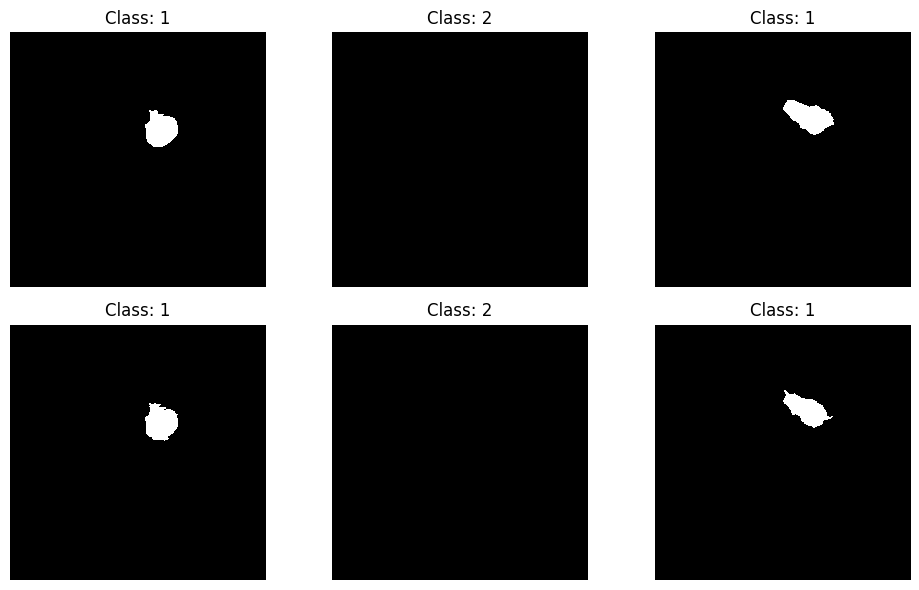

In [17]:
model.eval()
masks = []

with torch.no_grad():
    fig, ax = plt.subplots(2, 3, figsize=(10, 6))
    for i in range(3):
        image = test_dataset[i][0].to(device).unsqueeze(0)
        mask = test_dataset[i][1].to(device)
        target = test_dataset[i][2]

        output_class, output_seg = model(image)
        _, pred = torch.max(output_class, 1)
        
        output_seg=torch.sigmoid(output_seg).cpu().squeeze().numpy()
        output_seg = (output_seg > 0.5).astype(np.uint8)

           # Hàng 1: ảnh pred
        ax[0, i].imshow(output_seg, cmap='gray')
        ax[0, i].set_title(f"Class: {pred.cpu().numpy()[0]}")
        ax[0, i].axis('off')
    
        # Hàng 2: mask
        ax[1, i].imshow(mask.cpu().squeeze().numpy(), cmap='gray') 
        ax[1, i].set_title(f"Class: {target}")
        ax[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
        
        

Text(0, 0.5, 'Value')

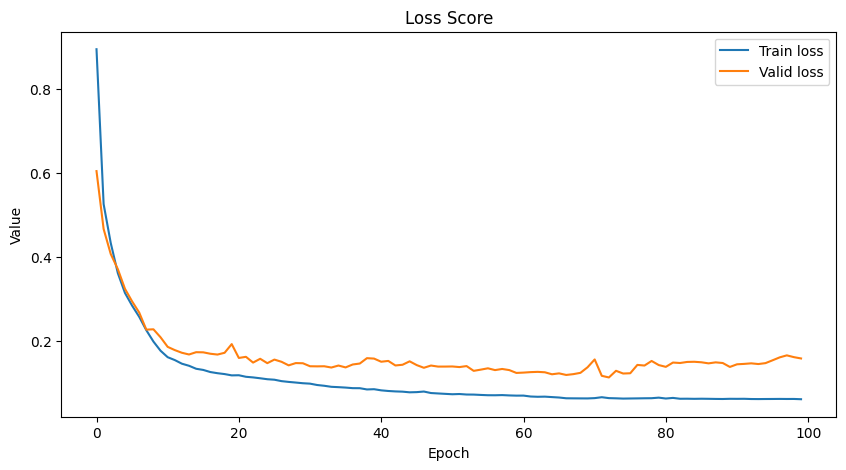

In [18]:
plt.figure(figsize=(10, 5))
plt.title("Loss Score")
plt.plot(results["train_loss"], label="Train loss")
plt.plot(results["valid_loss"], label="Valid loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Value")

Text(0, 0.5, 'Value')

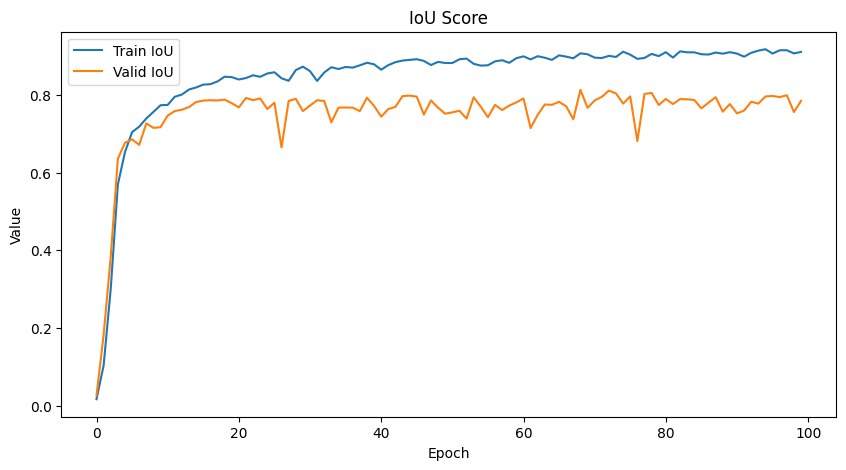

In [19]:
plt.figure(figsize=(10, 5))
plt.title("IoU Score")
plt.plot(results["iou_train"], label="Train IoU")
plt.plot(results["iou_valid"], label="Valid IoU")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Value")

Text(0, 0.5, 'Value')

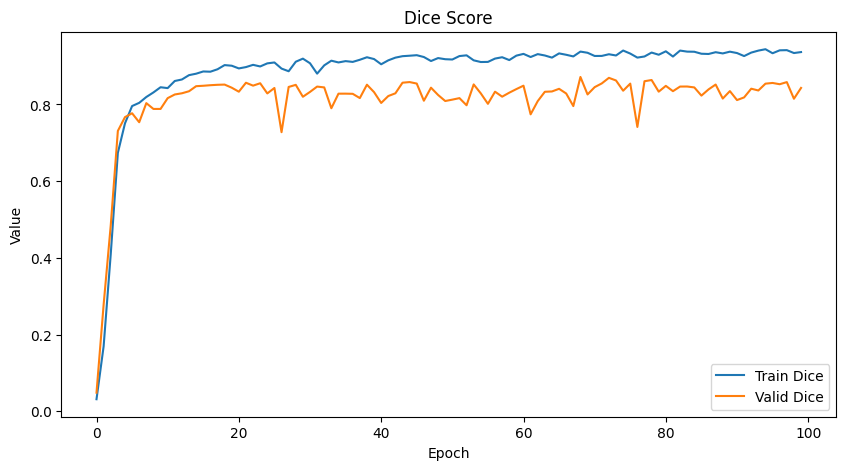

In [20]:
plt.figure(figsize=(10, 5))
plt.title("Dice Score")
plt.plot(results["dice_train"], label="Train Dice")
plt.plot(results["dice_valid"], label="Valid Dice")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Value")

Text(0, 0.5, 'Value')

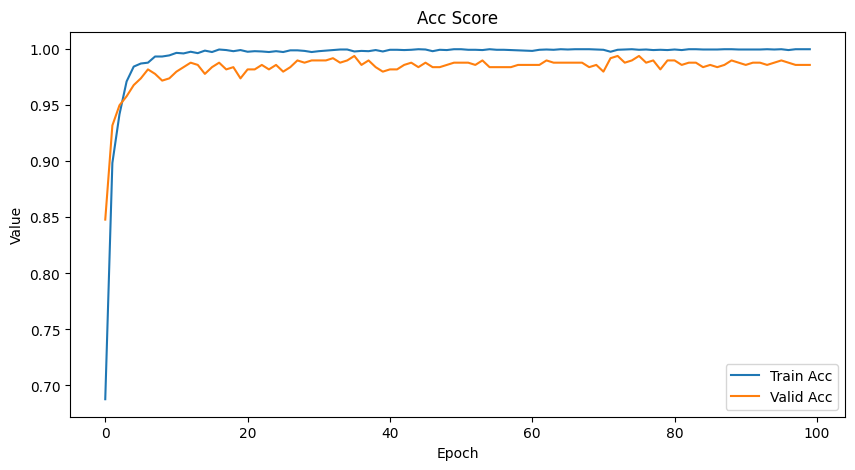

In [21]:
plt.figure(figsize=(10, 5))
plt.title("Acc Score")
plt.plot(results["acc_train"], label="Train Acc")
plt.plot(results["acc_valid"], label="Valid Acc")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Value")

IoU score : 0.7980097830295563
Dice score : 0.8565520606935024
------------------------------------------


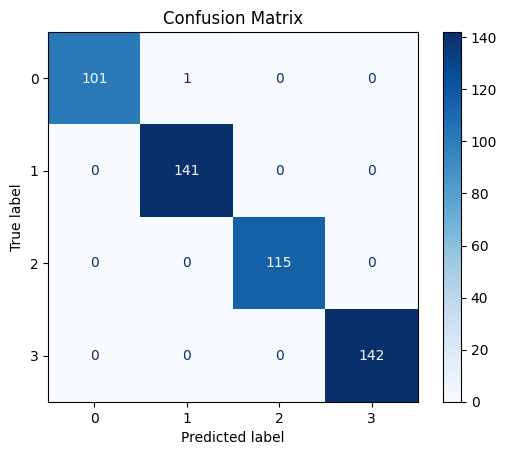

              precision    recall  f1-score   support

      glioma     1.0000    0.9902    0.9951       102
  meningioma     0.9930    1.0000    0.9965       141
    no_tumor     1.0000    1.0000    1.0000       115
   pituitary     1.0000    1.0000    1.0000       142

    accuracy                         0.9980       500
   macro avg     0.9982    0.9975    0.9979       500
weighted avg     0.9980    0.9980    0.9980       500



In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
true_labels = []        
pred_labels = []                
iou_total = 0
dice_total = 0
model.eval()                

with torch.no_grad():                        
    for i, (images, masks, targets) in enumerate(test_loader):
        
        images = images.to(device)
        masks = masks.to(device)
        targets = targets.to(device)
        
        output_class, output_seg = model(images)             
        _, preds = torch.max(output_class, 1)                

        # Lưu lại các giá trị thật và dự đoán                
        true_labels.extend(targets.cpu().numpy())                
        pred_labels.extend(preds.cpu().numpy())                       

        iou = calculate_iou(output_seg, masks)
        dice = calculate_dice(output_seg, masks)

        iou_total+= iou.item()
        dice_total += dice.item()

# IoU score and Dice score
print(f'IoU score : {iou_total / len(test_loader)}')
print(f'Dice score : {dice_total / len(test_loader)}')

print('------------------------------------------')
# Tạo ma trận nhầm lẫn        
cm = confusion_matrix(true_labels, pred_labels)        
disp = ConfusionMatrixDisplay(confusion_matrix=cm)        

# Hiển thị ma trận nhầm lẫn        
disp.plot(cmap=plt.cm.Blues)        
plt.title("Confusion Matrix")        
plt.show()               

print(classification_report(true_labels, pred_labels, target_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary'], digits = 4))